<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Findings</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Prepare-the-Script-to-Run-on-the-GPU-Platform" data-toc-modified-id="Prepare-the-Script-to-Run-on-the-GPU-Platform-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prepare the Script to Run on the GPU Platform</a></span><ul class="toc-item"><li><span><a href="#Output" data-toc-modified-id="Output-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Output</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Initialization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255, horizontal_flip = True, vertical_flip = True, rotation_range = 90)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


There are more than 7.5k photos in this dataset. No missing values found, data type is correct.

In [8]:
features, target = next(train_gen_flow)

## EDA

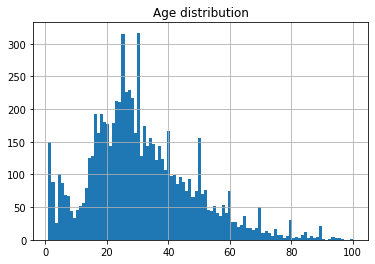

In [10]:
labels['real_age'].hist(bins=100)
plt.title('Age distribution');

In [11]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


The age is slightly positively skewed, close to normal distribution. Most people in these photos are in their 30-s.

### Findings

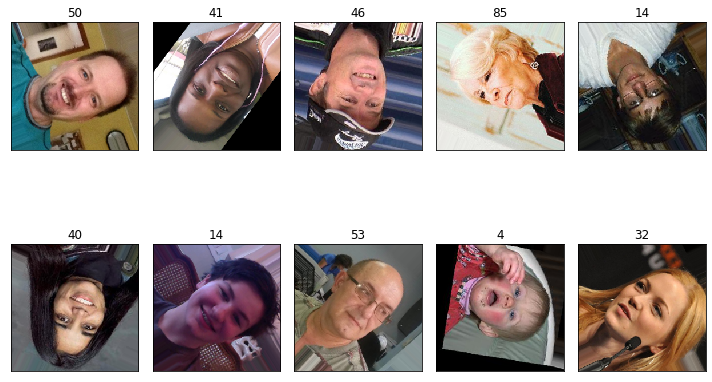

In [18]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(target[i])
    plt.imshow(features[i])
    # remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Based on the above analysis we can assume that a neural network model might overestimate the age of younger people and underestimate the age of elder people.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [21]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255, 
                                 horizontal_flip = True, vertical_flip = True, rotation_range = 90)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed=12345)
    
    features, target = next(train_gen_flow)
    
    return train_gen_flow

In [22]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
   
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed=12345)
    
    
    return test_gen_flow

In [23]:
def create_model(input_shape = (224, 224, 3)):
    
    """
    It defines the model
    """
    backbone = ResNet50(input_shape = input_shape, weights='imagenet', include_top=False)
        
    model = Sequential()
    optimizer = Adam(lr = 0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model

In [24]:
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps, verbose = 2)
    
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import pandas as pd
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError

labels = pd.read_csv('/datasets/faces/labels.csv')
path = '/datasets/faces/final_files/'

def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255, 
                                 horizontal_flip = True, vertical_flip = True, rotation_range = 90)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed=12345)
    
    features, target = next(train_gen_flow)
    
    return train_gen_flow

def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
   
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed=12345)
    
    
    return test_gen_flow

def create_model(input_shape = (224, 224, 3)):
    
    """
    It defines the model
    """
    backbone = ResNet50(input_shape = input_shape, weights='imagenet', include_top=False)
    
    #backbone.trainable = False
    
    model = Sequential()
    optimizer = Adam(lr = 0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps, verbose = 2)
    
    return model

"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

2021-07-06 22:36:16.433153: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-07-06 22:36:16.434871: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-07-06 22:36:17.670660: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-06 22:36:18.340268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-06 22:36:18.340346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-07-06 22:36:18.340379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-06 22:36:18.342052: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-07-06 22:36:18.342435: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-07-06 22:36:18.344035: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-07-06 22:36:18.344854: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-07-06 22:36:18.344927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-07-06 22:36:18.349279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-07-06 22:36:18.349645: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-07-06 22:36:18.355665: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2021-07-06 22:36:18.356133: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x53cbba0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-06 22:36:18.356154: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-07-06 22:36:18.497072: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5451bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-07-06 22:36:18.497112: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2021-07-06 22:36:18.499527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-06 22:36:18.499585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-07-06 22:36:18.499595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-06 22:36:18.499624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-07-06 22:36:18.499633: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-07-06 22:36:18.499642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-07-06 22:36:18.499650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-07-06 22:36:18.499657: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-07-06 22:36:18.503930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-07-06 22:36:18.503984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-07-06 22:36:18.808545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-06 22:36:18.808595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-07-06 22:36:18.808603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-07-06 22:36:18.813428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
2021-07-06 22:36:29.817243: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-06 22:36:30.245916: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 111s - loss: 238.0507 - mae: 11.4831 - val_loss: 518.3201 - val_mae: 17.6905
Epoch 2/15
178/178 - 105s - loss: 130.4126 - mae: 8.6775 - val_loss: 372.3543 - val_mae: 14.3999
Epoch 3/15
178/178 - 105s - loss: 114.9637 - mae: 8.1387 - val_loss: 328.7694 - val_mae: 13.5209
Epoch 4/15
178/178 - 105s - loss: 99.3656 - mae: 7.6396 - val_loss: 160.7536 - val_mae: 9.7296
Epoch 5/15
178/178 - 105s - loss: 90.4136 - mae: 7.2509 - val_loss: 126.5088 - val_mae: 8.2370
Epoch 6/15
178/178 - 105s - loss: 78.8866 - mae: 6.7982 - val_loss: 130.2701 - val_mae: 8.6988
Epoch 7/15
178/178 - 105s - loss: 68.7954 - mae: 6.3451 - val_loss: 106.1333 - val_mae: 7.7620
Epoch 8/15
178/178 - 105s - loss: 69.1231 - mae: 6.3893 - val_loss: 103.0418 - val_mae: 7.4103
Epoch 9/15
178/178 - 105s - loss: 60.5293 - mae: 5.9730 - val_loss: 125.1126 - val_mae: 8.2735
Epoch 10/15
178/178 - 105s - loss: 54.4631 - mae: 5.6687 - val_loss: 115.4493 - val_mae: 8.1687
Epoch 11/15
178/178 - 105s - loss: 49.7105 - mae: 5.4401 - val_loss: 101.6501 - val_mae: 7.7804
Epoch 12/15
178/178 - 105s - loss: 48.2884 - mae: 5.3060 - val_loss: 115.7894 - val_mae: 8.1450
Epoch 13/15
178/178 - 104s - loss: 44.9973 - mae: 5.1915 - val_loss: 102.4408 - val_mae: 7.4064
Epoch 14/15
178/178 - 105s - loss: 38.8483 - mae: 4.8066 - val_loss: 91.4407 - val_mae: 7.1568
Epoch 15/15
178/178 - 105s - loss: 35.4370 - mae: 4.5991 - val_loss: 101.2551 - val_mae: 7.4825
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

## Conclusion

The **goal** of this project was to develop a neural network model that predicts age of a person from a photograph.
The project metric is MAE and it should be no more than 8.

There are more than 7.5k photos in this dataset.
The age is slightly positively skewed, close to normal distribution. Most people in these photos are in their 30-s.
Based on that we can assume that a neural network model might overestimate the age of younger people and underestimate the age of elder people.

We have applied several data augmentation techniques to help the model train better:
- horizontal_flip;
- vertical_flip;
- 90 degree rotation_range.

The final model is based on the ResNet-50 - a convolutional neural network that is 50 layers deep. We have adde the GlobalAveragePooling2D layer and 3 fully connected layers after that.

The model showed the desired quality - after 15 epochs the validation **MAE is 7.48** (less than 8), which means that, on average, our model's predicted age diverges from the real age by slightly less than 8 years.